# Treinamento de Rede LSTM para classificação

## Libs

In [157]:
import re
import numpy as np
import pandas as pd
import seaborn as sns
from pathlib import Path
from textwrap import fill
from tqdm.auto import tqdm
import matplotlib.pyplot as plt

import kagglehub

import gensim.downloader as gd

import torch
from torch import nn
import torch.optim as optim
from torch.nn.utils.rnn import pad_sequence
from torch.utils.data import TensorDataset, DataLoader

from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

tqdm.pandas()

## Funções

In [158]:
def preprocess_text_to_embedding(text: str, embedding_model, max_seq_length: int = 100) -> torch.Tensor:
    # Remove HTML tags and non-alphanumeric characters
    text = re.sub(r"<.*?>", "", text)
    text = re.sub(r'[^a-zA-Z0-9]', ' ', text)
    
    # Convert to lowercase and split into words
    text = text.lower()
    words = text.split()
    
    # Truncate to max sequence length
    words = words[:max_seq_length]
    
    # Convert words to embeddings, ignoring words not in the embedding model
    embds = torch.tensor(np.array([embedding_model[w] for w in words if w in embedding_model]))
    
    return embds

## Preparação do Dataset

In [159]:
path = kagglehub.dataset_download("hgultekin/bbcnewsarchive")
path = Path(path)

print(f"Diretório principal: {path}")

print("- Arquivos e diretórios filhos:")
for file in path.iterdir():
    print(f"\t{file.name}")

Diretório principal: /home/miguel/.cache/kagglehub/datasets/hgultekin/bbcnewsarchive/versions/1
- Arquivos e diretórios filhos:
	bbc-news-data.csv


In [160]:
data = pd.read_csv(path / 'bbc-news-data.csv', sep='\t')
data.sample(5)

,category,filename,title,content
200,business,201.txt,Novartis hits acquisition trail,Swiss drugmaker Novartis has announced 5.65bn...
1326,sport,014.txt,McIlroy aiming for Madrid title,Northern Ireland man James McIlroy is confide...
263,business,264.txt,French suitor holds LSE meeting,European stock market Euronext has met with t...
1836,tech,013.txt,UK pioneers digital film network,The world's first digital cinema network will...
1147,politics,252.txt,Blair 'said he would stand down',Tony Blair promised Gordon Brown he would sta...


In [161]:
len(data)

2225

In [ ]:
# APENAS PARA TESTES
# data = data.sample(frac=0.6)
# data.head(5)

,category,filename,title,content
2186,tech,363.txt,Sony PSP handheld console hits US,"The latest handheld gaming gadget, Sony's Pla..."
156,business,157.txt,Khodorkovsky ally denies charges,A close associate of former Yukos boss Mikhai...
1940,tech,117.txt,Joke e-mail virus tricks users,A virus that disguises itself as a joke is sp...
1851,tech,028.txt,Piero gives rugby perspective,BBC Sport unveils its new analysis tool Piero...
1874,tech,051.txt,Blind student 'hears in colour',A blind student has developed software that t...


In [ ]:
# len(data)

1335

## Vizualização dos dados

/tmp/ipykernel_9833/3927542740.py:12: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=45)


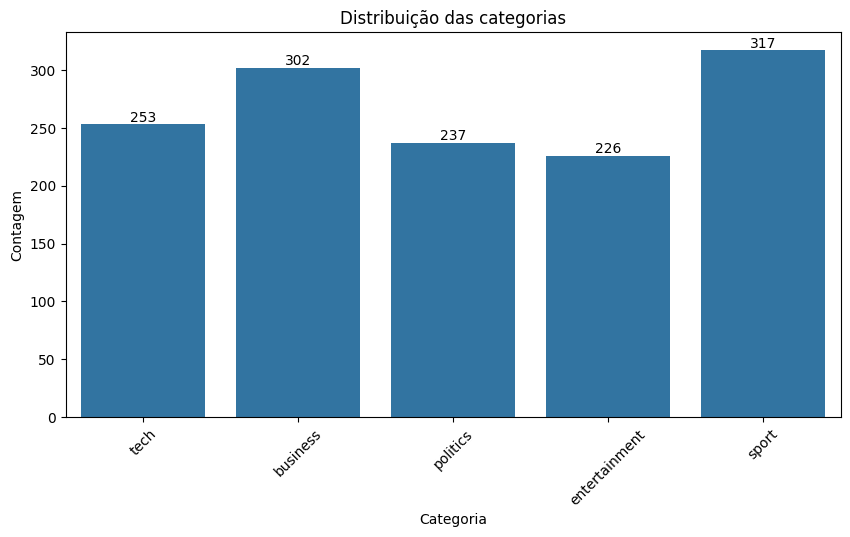

In [164]:
fig, ax = plt.subplots(figsize=(10, 5))

sns.countplot(x='category', data=data, ax=ax)

for p in ax.patches:
    ax.annotate(f'{p.get_height():.0f}', (p.get_x() + p.get_width() / 2., p.get_height()), 
                ha='center', va='center', fontsize=10, color='black', xytext=(0, 5), textcoords='offset points')

ax.set_title('Distribuição das categorias')
ax.set_xlabel('Categoria')
ax.set_ylabel('Contagem')
ax.set_xticklabels(ax.get_xticklabels(), rotation=45)

plt.show()

## Embeddings

In [165]:
gensim_embedding_model = gd.load("glove-twitter-50")

In [166]:
text = data.sample(1)["content"].values[0]

embds = preprocess_text_to_embedding(text=text, embedding_model=gensim_embedding_model)

print(f"Texto: {fill(text)}")
print(f"\nEmbeddings shape: {embds.shape}")

Texto:  The French economy picked up speed at the end of 2004, official
figures show - but still looks set to have fallen short of the
government's hopes.  According to state statistics body INSEE, growth
for the three months to December was a seasonally-adjusted 0.7-0.8%,
ahead of the 0.6% forecast. If confirmed, that would be the best
quarterly showing since early 2002. It leaves GDP up 2.3% for the full
year, but short of the 2.5% which the French government had predicted.
Despite the apparent shortfall in annual economic growth, the good
quarterly figures - a so-called "flash estimate" - mark a continuing
trend of improving indicators for the health of the French economy.
The government is reiterating a 2.5% target for 2005, while the
European Central Bank is making positive noises for the 12-nation
eurozone as a whole. Also on Friday, France's industrial output for
December was released, showing 0.7% growth. "The numbers are good,"
said David Naude, economist at Deutsche Bank. "Th

Pré-processando todas as linhas do dataset.

In [167]:
X = [
    preprocess_text_to_embedding(
        text=t,
        embedding_model=gensim_embedding_model
    ) for t in data["content"]
]

print(f"Total de amostras processadas: {len(X)}")

Total de amostras processadas: 1335


## Labels

In [168]:
encoder = LabelEncoder()

y = encoder.fit_transform(data["category"])
y = y.astype(np.int64)
y = torch.tensor(y)

y

tensor([4, 0, 4,  ..., 2, 2, 4])

## Dataset e Dataloader

In [169]:
x_padded = pad_sequence(X, batch_first=True)
x_padded.shape

torch.Size([1335, 100, 50])

In [170]:
x_train, x_test, y_train, y_test = train_test_split(x_padded, y, test_size=0.2)

x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.1)

train_ds = TensorDataset(x_train, y_train)
train_loader = DataLoader(train_ds, batch_size=64, shuffle=True)

val_ds = TensorDataset(x_val, y_val)
val_loader = DataLoader(val_ds, batch_size=64)

test_ds = TensorDataset(x_test, y_test)
test_loader = DataLoader(test_ds, batch_size=64)

print(f"Total de treino: {len(train_ds)}")
print(f"Total de validação: {len(val_ds)}")
print(f"Total de teste: {len(test_ds)}")

Total de treino: 961
Total de validação: 107
Total de teste: 267


## Model

In [171]:
class Model(nn.Module):
    def __init__(self, num_classes: int = 2):
        super().__init__()

        hidden_size = 32

        self.lstm = nn.LSTM(
            input_size=50,     # embedding size
            hidden_size=hidden_size,
            bidirectional=False,
            batch_first=True,
        )

        self.dropout = nn.Dropout(p=0.5)

        self.fc = nn.Linear(hidden_size, num_classes)

    def forward(self, sequence):
        _, (hidden, cell) = self.lstm(sequence)
        
        dropped = self.dropout(hidden.squeeze(0))
        
        prediction = self.fc(dropped)
        
        return prediction

num_classes = len(encoder.classes_)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

net = Model(num_classes=num_classes).to(device)

Using device: cpu


## Treinamento e avaliação

In [ ]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(net.parameters(), lr=1e-3)

history = []
n_epochs = 120

best_val_loss = float('inf')
best_model_path = 'best_model.pth'

# repete por um número de épocas
for epoch in range(n_epochs):
    # epoca de treinamento: itera sobre os batches do conjunto de treino
    net.train()
    running_loss = 0.0
    for i, data in enumerate(train_loader):
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()
        
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    running_loss /= len(train_ds)

    # avaliação no conjunto de teste
    net.eval()
    val_loss = 0.0
    with torch.no_grad():
        for data in val_loader:
            inputs, labels = data
            inputs, labels = inputs.to(device), labels.to(device)
            
            outputs = net(inputs)
            
            loss = criterion(outputs, labels)
            
            val_loss += loss.item()

    val_loss /= len(val_ds)
    
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        torch.save(net.state_dict(), best_model_path)

    history.append([running_loss, val_loss])

    if epoch % max(1, n_epochs // 20)  == 0:
        print(f'[{epoch + 1}] loss: {running_loss:.4f} val loss: {val_loss:.4f}')

print('Finished Training')

[1] loss: 0.0047 val loss: 0.0101
[7] loss: 0.0032 val loss: 0.0052
[13] loss: 0.0023 val loss: 0.0083
[19] loss: 0.0028 val loss: 0.0076
[25] loss: 0.0026 val loss: 0.0079
[31] loss: 0.0020 val loss: 0.0095
[37] loss: 0.0013 val loss: 0.0072
[43] loss: 0.0020 val loss: 0.0074
[49] loss: 0.0011 val loss: 0.0089
[55] loss: 0.0013 val loss: 0.0078
[61] loss: 0.0008 val loss: 0.0081
[67] loss: 0.0006 val loss: 0.0089
[73] loss: 0.0008 val loss: 0.0100
[79] loss: 0.0006 val loss: 0.0103
[85] loss: 0.0006 val loss: 0.0104
[91] loss: 0.0025 val loss: 0.0103
[97] loss: 0.0009 val loss: 0.0090
[103] loss: 0.0007 val loss: 0.0078
[109] loss: 0.0005 val loss: 0.0088
[115] loss: 0.0006 val loss: 0.0093
Finished Training


Evolução da **função de perda** nos conjuntos de treino e validação ao longo do treinamento. 

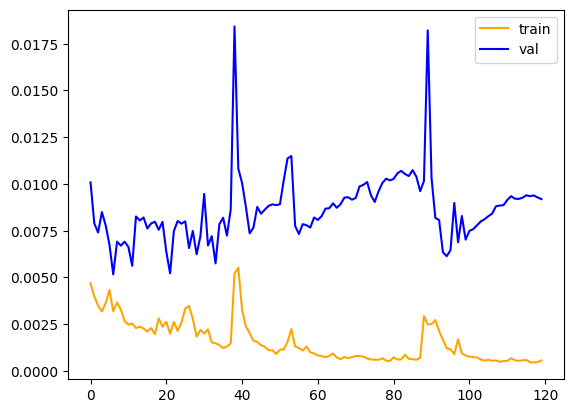

In [179]:
history = np.array(history)

plt.plot(history[:, 0], '-', color='orange', label='train')
plt.plot(history[:, 1], '-', color='blue', label='val')
plt.legend()

## Teste

In [180]:
all_labels = []
preds = []

best_model = Model(num_classes=num_classes).to(device)
best_model.load_state_dict(torch.load(best_model_path))
best_model.eval()

with torch.no_grad():
    for data in test_loader:
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)
        
        outputs = best_model(inputs)
        
        cls = np.argmax(outputs.cpu().numpy(), axis=-1)
        all_labels += list(labels.cpu().numpy())
        preds += list(cls)

print(classification_report(all_labels, preds))

              precision    recall  f1-score   support

           0       0.90      0.92      0.91        60
           1       0.97      0.76      0.85        46
           2       0.84      0.77      0.80        48
           3       0.89      1.00      0.94        62
           4       0.88      0.96      0.92        51

    accuracy                           0.89       267
   macro avg       0.90      0.88      0.88       267
weighted avg       0.89      0.89      0.89       267



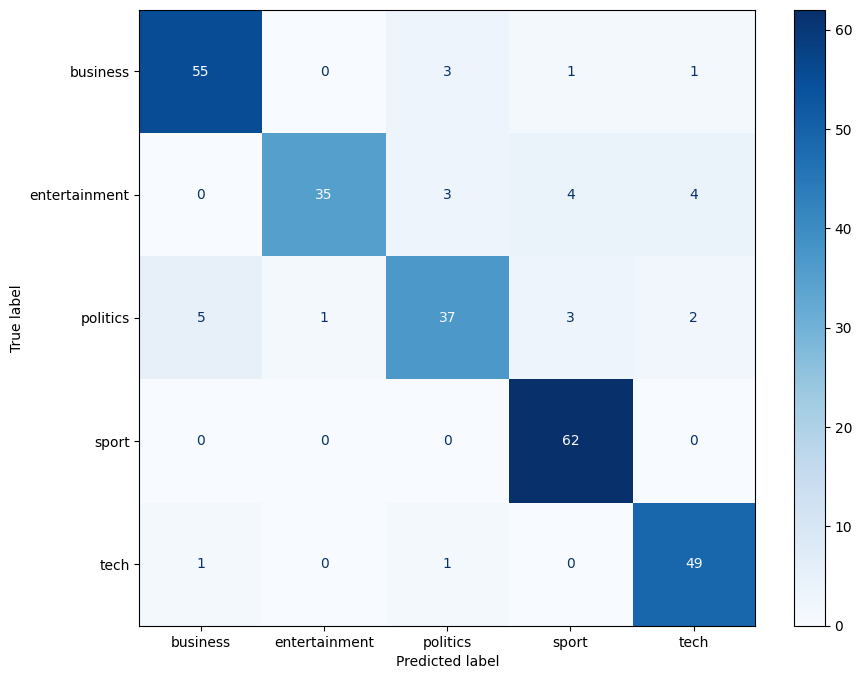

In [181]:
cm = confusion_matrix(all_labels, preds)

fig, ax = plt.subplots(figsize=(10, 8))

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=encoder.classes_)
disp.plot(cmap=plt.cm.Blues, ax=ax)

plt.show()